In [2]:
import arviz as az
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import jax.numpy as jnp
from jax import random

import numpyro
import numpyro.distributions as dist
from numpyro.infer import NUTS, MCMC, Predictive

%matplotlib inline

/Users/peng/miniforge3/envs/numpyro/lib/python3.9/site-packages/jax/_src/lib/__init__.py:32: UserWarning: JAX on Mac ARM machines is experimental and minimally tested. Please see https://github.com/google/jax/issues/5501 in the event of problems.
  warnings.warn("JAX on Mac ARM machines is experimental and minimally tested. "
/Users/peng/miniforge3/envs/numpyro/lib/python3.9/site-packages/jax/experimental/optimizers.py:28: FutureWarning: jax.experimental.optimizers is deprecated, import jax.example_libraries.optimizers instead
  warnings.warn('jax.experimental.optimizers is deprecated, '
/Users/peng/miniforge3/envs/numpyro/lib/python3.9/site-packages/jax/experimental/stax.py:28: FutureWarning: jax.experimental.stax is deprecated, import jax.example_libraries.stax instead
  warnings.warn('jax.experimental.stax is deprecated, '


In [3]:
cough_data = pd.read_csv("../data/ME2CoughData.csv")
cough_data.head()

,patient,dose,time,cough
0,1,0,4,0
1,1,0,8,1
2,1,0,12,0
3,1,0,16,0
4,1,0,20,0


In [5]:
data = cough_data.groupby(["dose", "time"])["cough"].aggregate("sum").reset_index()
data['frac'] = data['cough']/100
data['frac_log'] = np.log(data['frac'])
data.head()

,dose,time,cough,frac,frac_log
0,0,4,20,0.20,-1.609438
1,0,8,22,0.22,-1.514128
2,0,12,26,0.26,-1.347074
3,0,16,18,0.18,-1.714798
4,0,20,18,0.18,-1.714798


<AxesSubplot:xlabel='time', ylabel='frac'>

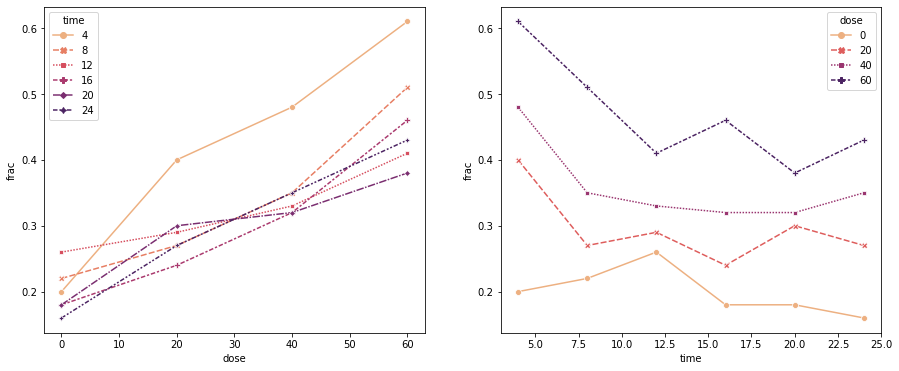

In [6]:
_,ax = plt.subplots(1, 2, figsize=(15,6))

# ax[0].plot(data['dose'], data['frac'], color=data['time'])
sns.lineplot(x=data['dose'], y=data['frac'], hue=data['time'], 
             palette='flare',style=data['time'], markers=True, 
             ax=ax[0])
sns.lineplot(x=data['time'], y=data['frac'], hue=data['dose'],
             palette='flare',style=data['dose'], markers=True,
             ax=ax[1])

<AxesSubplot:xlabel='time', ylabel='frac_log'>

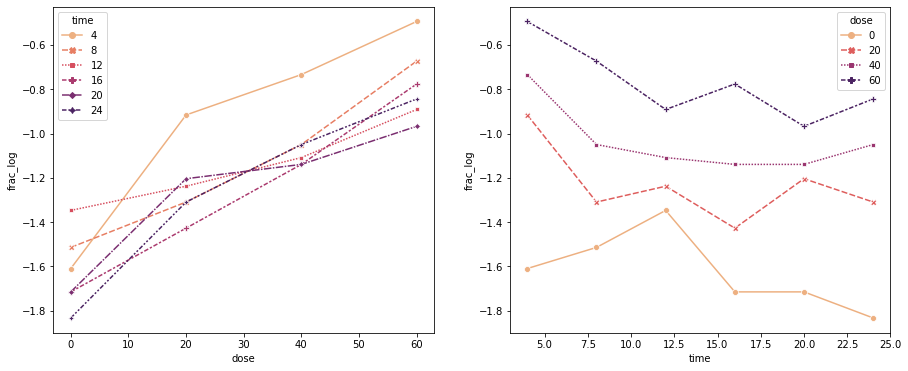

In [7]:
_,ax = plt.subplots(1, 2, figsize=(15,6))

# ax[0].plot(data['dose'], data['frac'], color=data['time'])
sns.lineplot(x=data['dose'], y=data['frac_log'], hue=data['time'], 
             palette='flare',style=data['time'], markers=True, 
             ax=ax[0])
sns.lineplot(x=data['time'], y=data['frac_log'], hue=data['dose'],
             palette='flare',style=data['dose'], markers=True,
             ax=ax[1])

In [35]:
cough_data.head()

,patient,dose,time,cough
0,1,0,4,0
1,1,0,8,1
2,1,0,12,0
3,1,0,16,0
4,1,0,20,0


In [8]:
n_ptt = cough_data['patient'].unique().shape[0]
ind_ptt = cough_data['patient'].values - 1

n_obs = cough_data.shape[0]

dose = cough_data['dose'].values

time = cough_data['time'].values

cough = cough_data['cough'].values

In [ ]:
def model(obs=None):
    # priors
    e0mean = numpyro.sample('e0mean', dist.Normal(0,10**6))
    alpha = numpyro.sample('alpha', dist.Normal(0, 10**6))
    x50 = numpyro.sample('x50', dist.LogNormal(0, 10**6))
    ktol = numpyro.sample('ktol', dist.LogNormal(0, 10**6))
    sigma = numpyro.sample('sigma', dist.Uniform(0,10**4))

    # likelihood
    ptt_plate = numpyro.plate("ptt_plate", n_ptt)
    obs_plate = numpyro.plate("obs_plate", n_obs)
    with ptt_plate:
        e0 = numpyro.sample('e0', dist.Normal(loc=e0mean, scale=sigma))
    with obs_plate:
        xtol = dose * (1 - jnp.exp(-ktol * time))
        prob_cough = numpyro.deterministic('prob_cough', e0[ind_ptt] 
                        + alpha * dose / (1 + xtol / x50))
        cough = numpyro.sample('cough', dist.Bernoulli(logits=prob_cough), obs=obs)

kernel = NUTS(model)
mcmc = MCMC(kernel, num_chains=3, num_warmup=3000, num_samples=3000, chain_method='sequential')
mcmc.run(random.PRNGKey(31), obs=cough)

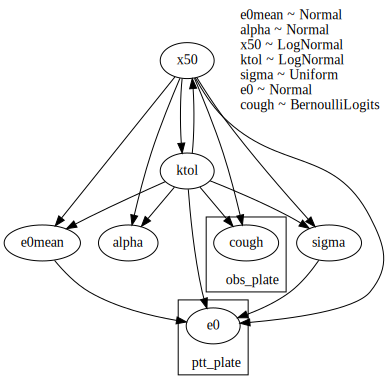

In [47]:
numpyro.render_model(model, render_distributions=True)

In [50]:
var_names = ['alpha', 'e0mean', 'ktol', 'sigma', 'x50']
az.summary(mcmc, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,538985.750,639628.312,0.029,1768438.250,217493.557,159297.817,5.0,36.0,1.67
e0mean,-1.965,0.224,-2.392,-1.531,0.011,0.008,400.0,456.0,1.03
ktol,0.147,0.080,0.000,0.254,0.028,0.021,9.0,41.0,1.25
sigma,1.489,0.106,1.293,1.691,0.004,0.003,674.0,2826.0,1.02
x50,3.569,8.166,0.000,20.290,2.957,2.176,5.0,32.0,1.65


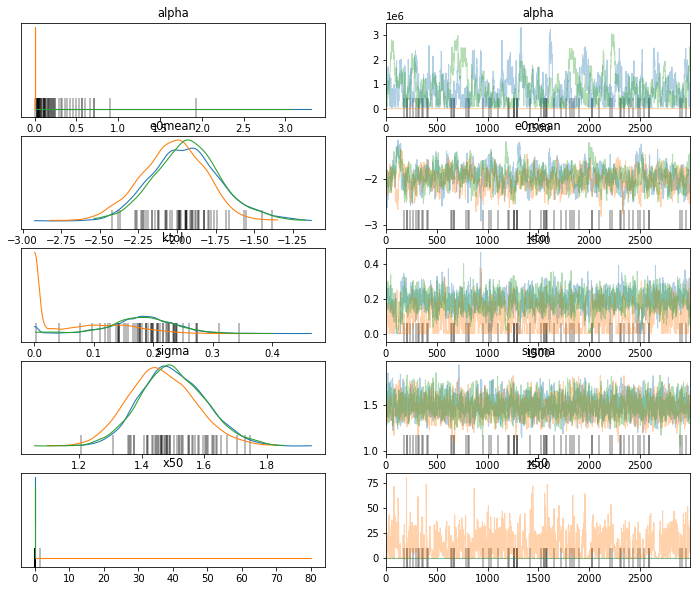

In [55]:
az.plot_trace(mcmc, var_names, compact=False)
plt.show()

In [21]:
def model2(obs=None):
    # priors
    e0mean = numpyro.sample('e0mean', dist.Normal(0,10**6))
    alpha = numpyro.sample('alpha', dist.Normal(0, 10**6))
    # x50 = numpyro.sample('x50', dist.LogNormal(0, 10**6))
    x50 = numpyro.sample('x50', dist.Uniform(5,200))
    # ktol = numpyro.sample('ktol', dist.LogNormal(0, 10**6))
    ktol = numpyro.sample('ktol', dist.Uniform(0.05, 2))
    sigma = numpyro.sample('sigma', dist.Uniform(0,10**4))

    # likelihood
    ptt_plate = numpyro.plate("ptt_plate", n_ptt)
    obs_plate = numpyro.plate("obs_plate", n_obs)
    with ptt_plate:
        e0 = numpyro.sample('e0', dist.Normal(loc=e0mean, scale=sigma))
    with obs_plate:
        xtol = dose * (1 - jnp.exp(-ktol * time))
        prob_cough = numpyro.deterministic('prob_cough', e0[ind_ptt] 
                        + alpha * dose / (1 + xtol / x50))
        cough = numpyro.sample('cough', dist.Bernoulli(logits=prob_cough), obs=obs)

kernel = NUTS(model2)
mcmc2 = MCMC(kernel, num_chains=3, num_warmup=3000, num_samples=1000, chain_method='sequential')
mcmc2.run(random.PRNGKey(31), obs=cough)

sample: 100%|██████████| 4000/4000 [00:08<00:00, 460.12it/s, 63 steps of size 5.61e-02. acc. prob=0.94] 


In [22]:
var_names = ['alpha', 'e0mean', 'ktol', 'sigma', 'x50']
az.summary(mcmc2, var_names=var_names)

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha,0.106,0.044,0.047,0.191,0.002,0.002,402.0,639.0,1.01
e0mean,-2.145,0.193,-2.487,-1.772,0.016,0.011,144.0,501.0,1.03
ktol,0.140,0.051,0.051,0.223,0.002,0.001,525.0,1009.0,1.01
sigma,1.481,0.110,1.265,1.672,0.005,0.004,494.0,952.0,1.01
x50,22.463,13.239,5.167,43.244,0.394,0.279,887.0,870.0,1.00


array([[<AxesSubplot:title={'center':'alpha'}>,
        <AxesSubplot:title={'center':'alpha'}>],
       [<AxesSubplot:title={'center':'e0mean'}>,
        <AxesSubplot:title={'center':'e0mean'}>],
       [<AxesSubplot:title={'center':'ktol'}>,
        <AxesSubplot:title={'center':'ktol'}>],
       [<AxesSubplot:title={'center':'sigma'}>,
        <AxesSubplot:title={'center':'sigma'}>],
       [<AxesSubplot:title={'center':'x50'}>,
        <AxesSubplot:title={'center':'x50'}>]], dtype=object)

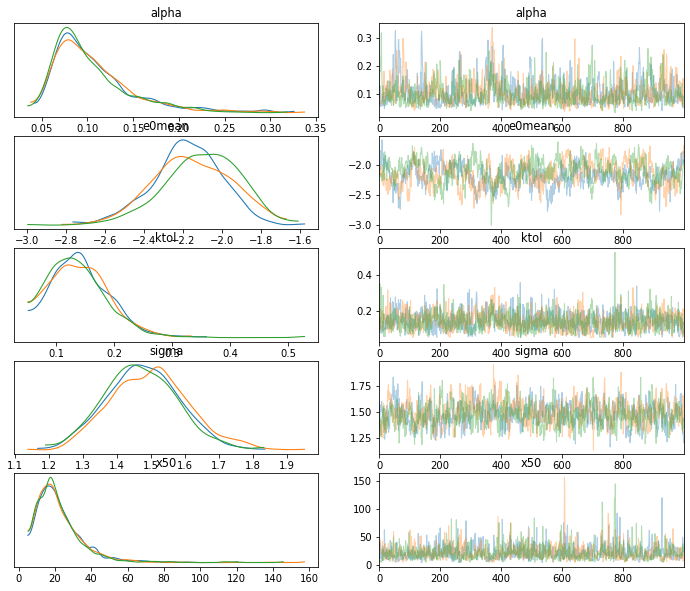

In [23]:
az.plot_trace(mcmc2, var_names, compact=False)

### Posterior Prediction for Same Patient

prediction of future observation in the **same subjects**, i.e., posterior predictions of the observed fraction of patients with >=1 pulmanory exacerbation in the **same group of patients**

In [30]:
# Posterior Predictive Check
pred = Predictive(model=mcmc2.sampler.model, posterior_samples=mcmc2.get_samples())
post_pred_samples = pred(random.PRNGKey(321))
post_pred_samples

{'cough': DeviceArray([[0, 1, 0, ..., 1, 0, 1],
              [0, 0, 0, ..., 0, 0, 0],
              [0, 0, 0, ..., 1, 0, 0],
              ...,
              [0, 0, 0, ..., 1, 0, 1],
              [0, 0, 0, ..., 1, 0, 1],
              [0, 0, 0, ..., 1, 0, 1]], dtype=int32),
 'prob_cough': DeviceArray([[-1.5871933 , -1.5871933 , -1.5871933 , ...,  0.9849774 ,
                0.89968497,  0.8467435 ],
              [-2.0692568 , -2.0692568 , -2.0692568 , ...,  1.0928407 ,
                1.0072391 ,  0.9535328 ],
              [-2.2069392 , -2.2069392 , -2.2069392 , ...,  0.74059546,
                0.68250823,  0.648702  ],
              ...,
              [-2.043293  , -2.043293  , -2.043293  , ...,  0.90638566,
                0.85418653,  0.8255062 ],
              [-0.97582066, -0.97582066, -0.97582066, ...,  0.22835052,
                0.16937399,  0.1369046 ],
              [-1.1270168 , -1.1270168 , -1.1270168 , ...,  1.1688144 ,
                1.1157032 ,  1.0863817 ]], dtype

In [79]:
pred_frac = np.exp(post_pred_samples['prob_cough']) /(1 + np.exp(post_pred_samples['prob_cough']))
pred_df = pd.DataFrame(pred_frac.T)
pred_df['dose'] = dose
pred_df['time'] = time
pred_df = pred_df.groupby(['dose', 'time']).mean().unstack().unstack().reset_index()
pred_df.columns = ['sample_ind', 'time', 'dose', 'prob']
# pred_df.groupby(['dose', 'time'])['prob'].apply(lambda x: np.percentile(x, 5))
# pred_df.groupby(['dose', 'time'])['prob'].apply(lambda x: np.percentile(x, 95))
# pred_df.groupby(['dose', 'time'])['prob'].apply(lambda x: np.mean(x))

In [80]:
predictions = pd.DataFrame({
    "dose": data['dose'],
    "time": data['time'],
    "true_frac": data['frac'],
    "pred_frac_mean": pred_df.groupby(['dose', 'time'])['prob'].apply(lambda x: np.mean(x)).values,
    "pred_frac_perc_5": pred_df.groupby(['dose', 'time'])['prob'].apply(lambda x: np.percentile(x, 2.5)).values,
    "pred_frac_perc_95": pred_df.groupby(['dose', 'time'])['prob'].apply(lambda x: np.percentile(x, 97.5)).values
})
predictions

,dose,time,true_frac,pred_frac_mean,pred_frac_perc_5,pred_frac_perc_95
0,0,4,0.20,0.193863,0.167679,0.219213
1,0,8,0.22,0.193863,0.167679,0.219213
2,0,12,0.26,0.193863,0.167679,0.219213
3,0,16,0.18,0.193863,0.167679,0.219213
4,0,20,0.18,0.193863,0.167679,0.219213
5,0,24,0.16,0.193863,0.167679,0.219213
6,20,4,0.40,0.343630,0.298737,0.395694
7,20,8,0.27,0.310203,0.280265,0.340882
8,20,12,0.29,0.296218,0.268808,0.324159
9,20,16,0.24,0.289231,0.262061,0.316758


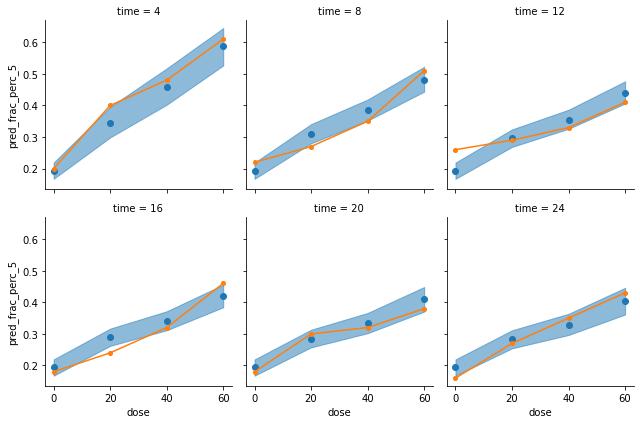

In [75]:
# Individual Predictions: frac of ptts with cough vs dose
grid = sns.FacetGrid(predictions, col='time', col_wrap=3)
grid.map(plt.plot, "dose", "true_frac", color='C1',marker='.', ms=8)
grid.map(plt.scatter, "dose", "pred_frac_mean", color="C0")
grid.map(plt.fill_between, "dose", 
            "pred_frac_perc_5", 
            "pred_frac_perc_95", alpha=0.5)

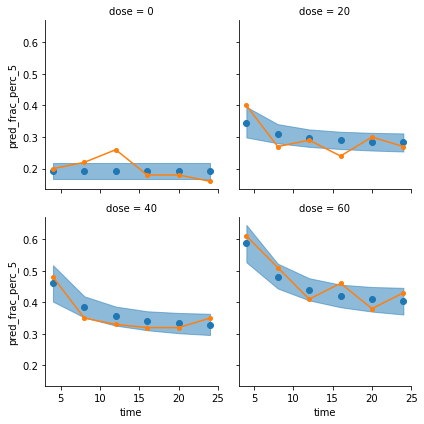

In [76]:
# Individual Predictions: frac of ptts with cough vs time
grid = sns.FacetGrid(predictions, col='dose', col_wrap=2)
grid.map(plt.plot, "time", "true_frac", color='C1',marker='.', ms=8)
grid.map(plt.scatter, "time", "pred_frac_mean", color="C0")
grid.map(plt.fill_between, "time", 
            "pred_frac_perc_5", 
            "pred_frac_perc_95", alpha=0.5)

### Posterior Prediction for New Patient

prediction of future observations in **new subjects**, i.e., posterior predictions of the observed fraction of patients with >=1 pulmonary exacerbation **assuming the same number of patients with the same covariates**

In [81]:
# Population Predictions
pred_event = post_pred_samples['cough']
pred_df = pd.DataFrame(pred_event.T)
pred_df['dose'] = dose
pred_df['time'] = time
pred_df = pred_df.groupby(['dose', 'time']).mean().unstack().unstack().reset_index()
pred_df.columns = ['sample_ind', 'time', 'dose', 'prob']
pred_df.groupby(['dose', 'time'])['prob'].apply(lambda x: np.percentile(x, 5))
pred_df.groupby(['dose', 'time'])['prob'].apply(lambda x: np.percentile(x, 95))
pred_df.groupby(['dose', 'time'])['prob'].apply(lambda x: np.mean(x))

dose  time
0     4       0.194093
      8       0.193163
      12      0.193347
      16      0.193760
      20      0.193120
      24      0.193987
20    4       0.343623
      8       0.308653
      12      0.296633
      16      0.288780
      20      0.284913
      24      0.282363
40    4       0.459633
      8       0.385640
      12      0.354267
      16      0.341647
      20      0.333233
      24      0.329270
60    4       0.587520
      8       0.481927
      12      0.440087
      16      0.419040
      20      0.409833
      24      0.402583
Name: prob, dtype: float64

In [82]:
predictions = pd.DataFrame({
    "dose": data['dose'],
    "time": data['time'],
    "true_frac": data['frac'],
    "pred_frac_mean": pred_df.groupby(['dose', 'time'])['prob'].apply(lambda x: np.mean(x)).values,
    "pred_frac_perc_5": pred_df.groupby(['dose', 'time'])['prob'].apply(lambda x: np.percentile(x, 2.5)).values,
    "pred_frac_perc_95": pred_df.groupby(['dose', 'time'])['prob'].apply(lambda x: np.percentile(x, 97.5)).values
})
predictions

,dose,time,true_frac,pred_frac_mean,pred_frac_perc_5,pred_frac_perc_95
0,0,4,0.20,0.194093,0.13000,0.26000
1,0,8,0.22,0.193163,0.13000,0.26000
2,0,12,0.26,0.193347,0.13000,0.27000
3,0,16,0.18,0.193760,0.13000,0.27000
4,0,20,0.18,0.193120,0.13000,0.26000
5,0,24,0.16,0.193987,0.13000,0.27000
6,20,4,0.40,0.343623,0.25000,0.44000
7,20,8,0.27,0.308653,0.22975,0.39000
8,20,12,0.29,0.296633,0.22000,0.38000
9,20,16,0.24,0.288780,0.21000,0.37000


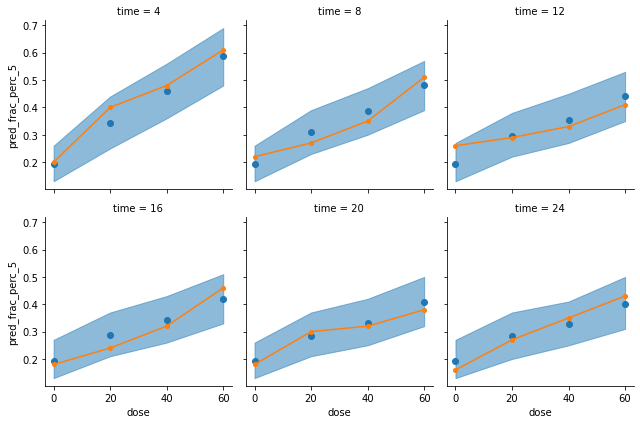

In [83]:
# Population Predictions: frac of ptts with cough vs dose
grid = sns.FacetGrid(predictions, col='time', col_wrap=3)
grid.map(plt.plot, "dose", "true_frac", color='C1',marker='.', ms=8)
grid.map(plt.scatter, "dose", "pred_frac_mean", color="C0")
grid.map(plt.fill_between, "dose", 
            "pred_frac_perc_5", 
            "pred_frac_perc_95", alpha=0.5)

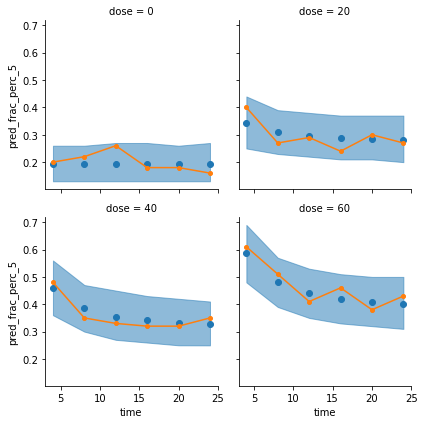

In [84]:
# Population Predictions: frac of ptts with cough vs time
grid = sns.FacetGrid(predictions, col='dose', col_wrap=2)
grid.map(plt.plot, "time", "true_frac", color='C1',marker='.', ms=8)
grid.map(plt.scatter, "time", "pred_frac_mean", color="C0")
grid.map(plt.fill_between, "time", 
            "pred_frac_perc_5", 
            "pred_frac_perc_95", alpha=0.5)